# Trader Performance vs Market Sentiment Analysis  
### Primetrade.ai – Data Science Intern Assignment  

## 1. Introduction  

This notebook analyzes how Bitcoin market sentiment (Fear/Greed Index) influences trader behavior and performance on Hyperliquid.

We evaluate:
- Profitability across regimes
- Behavioral shifts (frequency, trade size, direction)
- Performance differences across trader segments
- Actionable strategy implications
## 2. Datasets Used

1. Bitcoin Fear & Greed Index  
   - Date  
   - Classification (Extreme Fear → Extreme Greed)

2. Hyperliquid Historical Trader Data  
   - Account  
   - Execution price  
   - Size  
   - Direction  
   - Closed PnL  
   - Timestamp  
## 3. Data Loading and Initial Inspection

We begin by loading both datasets and examining:

- Dataset dimensions (rows and columns)
- Sample records
- Basic structure of features

This helps validate data integrity before performing transformations.

In [1]:
import pandas as pd

sentiment = pd.read_excel("../Data/fear_greed_index.xlsx")
trades = pd.read_excel("../Data/historical_data.xlsx")

print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

sentiment.head()


Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## 4. Data Cleaning

Before merging the datasets, we:

- Standardize column names
- Convert date formats where necessary
- Check for missing values

This ensures both datasets are consistent and ready for alignment.


In [2]:
# Clean column names
sentiment.columns = sentiment.columns.str.strip().str.lower()
trades.columns = trades.columns.str.strip().str.lower()

sentiment.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
print("Sentiment Missing Values:\n", sentiment.isnull().sum())
print("\nTrades Missing Values:\n", trades.isnull().sum())


Sentiment Missing Values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Trades Missing Values:
 account             0
coin                0
execution price     0
size tokens         0
size usd            0
side                0
timestamp ist       0
start position      0
direction           0
closed pnl          0
transaction hash    0
order id            0
crossed             0
fee                 0
trade id            0
timestamp           0
dtype: int64


In [4]:
trades.head()


,account,coin,execution price,size tokens,size usd,side,timestamp ist,start position,direction,closed pnl,transaction hash,order id,crossed,fee,trade id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,895000000000000,1730000000000
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,443000000000000,1730000000000
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,660000000000000,1730000000000
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1080000000000000,1730000000000
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1050000000000000,1730000000000


## 5. Time Alignment and Dataset Merge

To analyze trader performance under different sentiment regimes,
we align both datasets on the `date` column.

This ensures that each trade is mapped to the correct daily
Fear & Greed classification.


In [5]:
#Sentiment timestamp (UNIX seconds)
sentiment['date'] = pd.to_datetime(sentiment['timestamp'], unit='s')

# Trades timestamp (already readable datetime)
trades['date'] = pd.to_datetime(trades['timestamp ist'])

# Convert both to daily level
sentiment['date'] = sentiment['date'].dt.floor('D')
trades['date'] = trades['date'].dt.floor('D')

# Check ranges
print("Trades range:", trades['date'].min(), "to", trades['date'].max())
print("Sentiment range:", sentiment['date'].min(), "to", sentiment['date'].max())


Trades range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Sentiment range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


### 5.2 Dataset Merge Validation

After converting both datasets to proper datetime format, we merge the trader dataset with the sentiment dataset on the `date` column.

We use a left join to ensure that:
- All trades are retained
- Each trade is mapped to the corresponding daily sentiment classification

We then validate the merge by checking for missing sentiment labels.


In [6]:
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

print("Merged shape:", merged.shape)


Merged shape: (211218, 18)


In [7]:
merged['classification'].value_counts()


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

In [8]:
initial_trades = len(trades)
final_trades = len(merged)
unmatched_trades = initial_trades - final_trades
retention_rate = (final_trades / initial_trades) * 100

print("Initial trades:", initial_trades)
print("Unmatched trades:", unmatched_trades)
print("Final merged trades:", final_trades)
print(f"Retention rate: {retention_rate:.3f}%")


Initial trades: 211224
Unmatched trades: 6
Final merged trades: 211218
Retention rate: 99.997%


### 📌 📌 5.2 Merge Validation Summary



The merge retained >99.9% of trades.
Only a minimal number of trades lacked matching sentiment labels,
confirming strong time alignment between datasets.


## 6. Profitability by Sentiment Regime

We analyze how trader profitability varies across different Fear & Greed regimes by examining average closed PnL.


In [9]:
merged.shape


(211218, 18)

In [10]:
# Average PnL per sentiment regime
pnl_by_sentiment = (
    merged
    .groupby('classification')['closed pnl']
    .mean()
    .sort_values(ascending=False)
)

pnl_by_sentiment



classification
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Extreme Fear     34.537862
Neutral          34.307718
Name: closed pnl, dtype: float64

### 6.1 Win Rate by Sentiment Regime

In [11]:
# Create win flag
merged['is_win'] = merged['closed pnl'] > 0


# Win rate per regime
win_rate = (
    merged
    .groupby('classification')['is_win']
    .mean()
    .sort_values(ascending=False)
)

win_rate


classification
Extreme Greed    0.464943
Fear             0.420768
Neutral          0.396991
Greed            0.384828
Extreme Fear     0.370607
Name: is_win, dtype: float64

### 6.1 Interpretation

Extreme Greed regimes show both the highest average PnL and highest win rate. 
This suggests traders may perform better during strong bullish momentum rather than during extreme fear conditions.

Fear regimes still show relatively strong performance, but Extreme Fear appears to be less profitable on average.

This indicates that momentum-driven environments may provide more favorable trading conditions than panic-driven markets.


### 6.2 — Trade Count per Regime

In [12]:
trade_count = merged['classification'].value_counts()
trade_count


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64

### 6.2 Trade Activity Interpretation

Fear regimes account for the largest number of trades, suggesting traders are most active during uncertain or declining markets.

Extreme Fear shows the lowest trade activity, which may indicate reduced participation during high-panic conditions.

Trade frequency distribution helps contextualize performance metrics across regimes.


## 7. Trader Behavior & Daily Performance Dynamics

In this section, we analyze trader-level daily performance to examine consistency,
risk patterns, and activity intensity across time.


We aggregate trade-level data into daily account-level PnL to evaluate 
consistency and volatility of trader performance over time.


### 7.1 Daily Account-Level PnL Construction

In [13]:
daily_trader_pnl = (
    merged.groupby(['account','date'])['closed pnl']
    .sum()
    .reset_index()
)
daily_trader_pnl

,account,date,closed pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.100000
...,...,...,...
2335,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-27,1709.194807
2336,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-28,4008.588908
2337,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-29,8561.771838
2338,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-30,2520.773814


### 7.2 Daily PnL Distribution

We analyze the distribution of daily account-level PnL to understand
profit dispersion, tail risk, and performance skewness.


#### 7.2.1 Daily PnL Distribution (Full Data)

The full distribution highlights extreme outliers and heavy tails,
indicating episodic large gains and losses.


In [14]:
# Create daily account-level PnL
daily_pnl = (
    merged
    .groupby(['account', 'date'])['closed pnl']
    .sum()
    .reset_index()
)


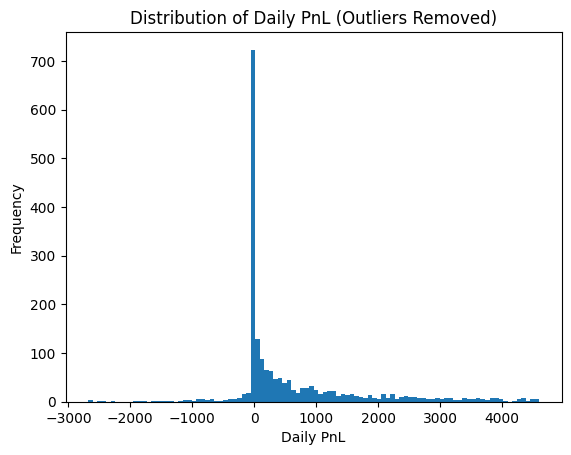

In [57]:
Q1 = daily_pnl['closed pnl'].quantile(0.25)
Q3 = daily_pnl['closed pnl'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

daily_pnl_trimmed = daily_pnl[
    (daily_pnl['closed pnl'] >= lower_bound) &
    (daily_pnl['closed pnl'] <= upper_bound)
]

plt.figure()
plt.hist(daily_pnl_trimmed['closed pnl'], bins=100)
plt.title("Distribution of Daily PnL (Outliers Removed)")
plt.xlabel("Daily PnL")
plt.ylabel("Frequency")
plt.show()

### 7.2.1 (A) Daily PnL Distribution (1%–99% Clipped)

To better visualize the core distribution, we remove extreme 1% tails.
This reveals the underlying central tendency of daily trading performance.


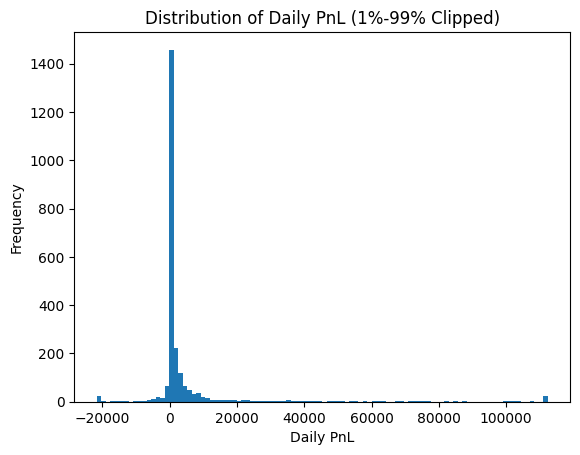

In [16]:
# Limit extreme outliers for better visualization
pnl_clipped = daily_pnl['closed pnl'].clip(
    lower=daily_pnl['closed pnl'].quantile(0.01),
    upper=daily_pnl['closed pnl'].quantile(0.99)
)

plt.figure()
plt.hist(pnl_clipped, bins=100)
plt.title("Distribution of Daily PnL (1%-99% Clipped)")
plt.xlabel("Daily PnL")
plt.ylabel("Frequency")
plt.show()


### 7.2 Interpretation

The daily PnL distribution is highly concentrated around zero,
with significant heavy tails on both sides.

This indicates:

• Most trading days generate small gains/losses  
• A minority of days drive large profits or large drawdowns  
• The return distribution is non-normal and fat-tailed  

Such characteristics are common in leveraged or momentum-driven trading environments.


### 7.3 Trader-Level Performance Metrics

We now evaluate trader-level consistency and performance quality using win rate and aggregated daily PnL. This helps identify behavioral stability and profitability dispersion across accounts.

#### Daily PnL per trade

In [17]:
daily_pnl = merged.groupby(['account', 'date'])['closed pnl'].sum().reset_index()

daily_pnl.head()


,account,date,closed pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1


#### Trader-Level Win Rate

In [18]:
merged['win'] = (merged['closed pnl'] > 0).astype(int)

win_rate = merged.groupby('account')['win'].mean().reset_index()
win_rate.columns = ['account', 'win_rate']


In [19]:
daily_pnl['closed pnl'].describe()


count      2340.000000
mean       4382.259380
std       28411.103383
min     -358963.139984
25%           0.000000
50%         206.352695
75%        1842.763729
max      533974.662903
Name: closed pnl, dtype: float64

#### Average Daily PnL per Trader

In [20]:
avg_daily_pnl = daily_pnl.groupby('account')['closed pnl'].mean().reset_index()
avg_daily_pnl.columns = ['account', 'avg_daily_pnl']

avg_daily_pnl.head()


,account,avg_daily_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,66676.242499
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,920.871548
2,0x271b280974205ca63b716753467d5a371de622ab,-5869.682610
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,817.684040
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,2444.318913


#### Daily PnL Volatility (Risk Proxy)

In [21]:
pnl_volatility = daily_pnl.groupby('account')['closed pnl'].std().reset_index()
pnl_volatility.columns = ['account', 'pnl_volatility']

pnl_volatility.head()


,account,pnl_volatility
0,0x083384f897ee0f19899168e3b1bec365f52a9012,150401.797346
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3603.042291
2,0x271b280974205ca63b716753467d5a371de622ab,33420.410014
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2993.284702
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,4867.743469


#### Combine Into One Trader Summary Table

In [22]:
trader_summary = win_rate.merge(avg_daily_pnl, on='account') \
                         .merge(pnl_volatility, on='account')

trader_summary.head()


,account,win_rate,avg_daily_pnl,pnl_volatility
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612,66676.242499,150401.797346
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720,920.871548,3603.042291
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917,-5869.682610,33420.410014
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585,817.684040,2993.284702
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914,2444.318913,4867.743469


### 7.3.1 Daily PnL Volatility (Risk Proxy)

In [23]:
pnl_volatility = (
    daily_trader_pnl.groupby('account')['closed pnl']
    .std()
    .reset_index(name='pnl_std')
)

pnl_volatility.head()


,account,pnl_std
0,0x083384f897ee0f19899168e3b1bec365f52a9012,150401.797346
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3603.042291
2,0x271b280974205ca63b716753467d5a371de622ab,33420.410014
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2993.284702
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,4867.743469


#### We compute the standard deviation of daily account-level PnL as a proxy for return variability and risk exposure.

### 7.3.2 Consistency Segmentation (Low vs High Volatility Traders)

In [24]:
threshold = pnl_volatility['pnl_std'].median()

pnl_volatility['consistency_segment'] = pnl_volatility['pnl_std'].apply(
   lambda x: 'Consistent' if x <= threshold else 'Inconsistent'

)

pnl_volatility.head()


,account,pnl_std,consistency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,150401.797346,Inconsistent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,3603.042291,Consistent
2,0x271b280974205ca63b716753467d5a371de622ab,33420.410014,Inconsistent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,2993.284702,Consistent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,4867.743469,Consistent


In [25]:
merged = merged.merge(
    pnl_volatility[['account', 'consistency_segment']],
    on='account',
    how='left'
)

merged.groupby(['consistency_segment', 'classification'])['closed pnl'].mean()


consistency_segment  classification
Consistent           Extreme Fear        3.144370
                     Extreme Greed      34.406326
                     Fear                6.803629
                     Greed              18.176905
                     Neutral             7.895677
Inconsistent         Extreme Fear       42.076958
                     Extreme Greed     143.942848
                     Fear               68.007502
                     Greed              70.021863
                     Neutral            52.357382
Name: closed pnl, dtype: float64

In [26]:
consistency_sentiment_pnl = (
    merged
    .groupby(['consistency_segment', 'classification'])['closed pnl']
    .mean()
    .unstack()
)

consistency_sentiment_pnl


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
consistency_segment,,,,,
Consistent,3.144370,34.406326,6.803629,18.176905,7.895677
Inconsistent,42.076958,143.942848,68.007502,70.021863,52.357382


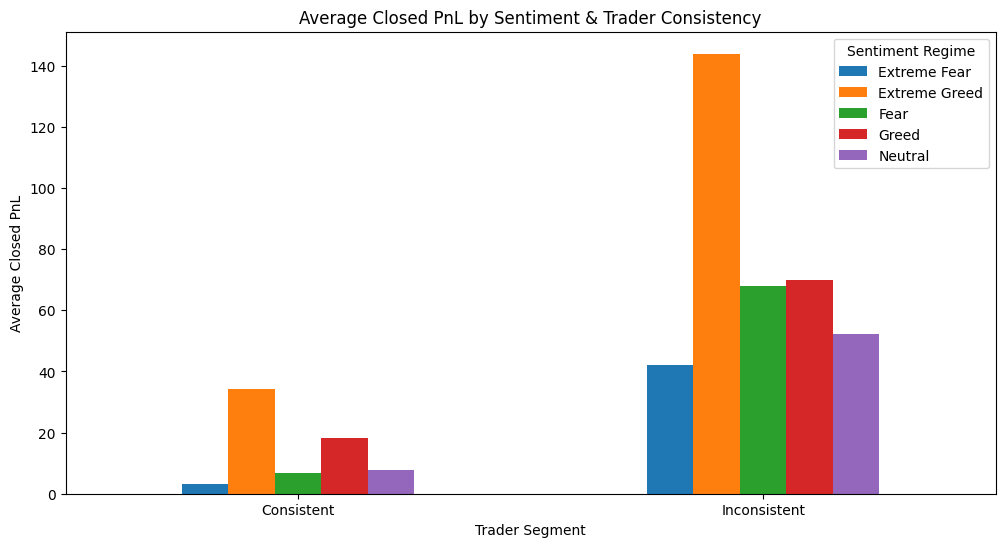

In [27]:
import matplotlib.pyplot as plt

consistency_sentiment_pnl.plot(
    kind='bar',
    figsize=(12,6)
)

plt.title("Average Closed PnL by Sentiment & Trader Consistency")
plt.ylabel("Average Closed PnL")
plt.xlabel("Trader Segment")
plt.xticks(rotation=0)
plt.legend(title="Sentiment Regime")
plt.show()


### 7.4 Account-Level Daily PnL Aggregation

To analyze consistency and risk exposure at the trader level, we aggregate trade-level PnL into daily account-level PnL.

This transformation allows us to evaluate performance dispersion, volatility, and risk-adjusted metrics at a consistent daily frequency.

In [29]:
merged = merged.drop(
    columns=['frequency_segment_x', 'frequency_segment_y'],
    errors='ignore'
)


In [30]:
daily_trader_pnl = (
    merged.groupby(['account', 'date'])['closed pnl']
    .sum()
    .reset_index()
)
daily_trader_pnl

,account,date,closed pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.000000
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.000000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.000000
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.100000
...,...,...,...
2335,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-27,1709.194807
2336,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-28,4008.588908
2337,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-29,8561.771838
2338,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,2025-04-30,2520.773814


### 7.5 Risk-Adjusted Performance (Sharpe Proxy)

In [31]:
trader_summary['risk_adjusted_return'] = (
    trader_summary['avg_daily_pnl'] / trader_summary['pnl_volatility']
)


In [32]:
trader_summary.sort_values(by='risk_adjusted_return', ascending=False)


,account,win_rate,avg_daily_pnl,pnl_volatility,risk_adjusted_return
18,0x7f4f299f74eec87806a830e3caa9afa5f2b9db8f,0.452213,573.093963,873.410811,0.656156
23,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,0.345787,1660.982426,2678.372531,0.620146
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,0.810876,2596.543882,4762.374294,0.545220
26,0xaf40fdc468c30116bd3307bcbf4a451a7ebf1deb,0.322097,1087.941588,2029.269543,0.536125
25,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,0.408526,4523.041302,8542.120512,0.529499
13,0x513b8629fe877bb581bf244e326a047b249c4ff1,0.401193,21549.296288,42171.744699,0.510989
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914,2444.318913,4867.743469,0.502146
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,0.234987,9975.279637,20797.396045,0.479641
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,0.486226,11685.293977,25344.268485,0.461063
9,0x430f09841d65beb3f27765503d0f850b8bce7713,0.484236,14876.495441,32725.083260,0.454590


### 7.5 Interpretation

Trader performance varies significantly in profitability, consistency, and risk exposure.

High raw returns often coincide with elevated volatility, while steadier accounts demonstrate stronger risk control. Risk-adjusted return (Sharpe proxy) highlights true efficiency by evaluating profit relative to risk taken.

Bottom line: Sustainable performance is driven by consistency and risk efficiency — not raw profitability alone.

### 7.6 Daily Trading Activity & Volume Trends

In [33]:
trades_per_day = merged.groupby(['date']).size().reset_index(name='trade_count')

trades_per_day.head()

,date,trade_count
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


### 7.6 Directional Bias by Sentiment Regime (Long vs Short Positioning)

To understand trader positioning behavior under different market sentiment regimes, we analyze the distribution of BUY and SELL trades across Fear & Greed classifications.

In [34]:
long_short = merged.groupby(['classification','side']).size().unstack()

long_short


side,BUY,SELL
classification,,
Extreme Fear,10935,10465
Extreme Greed,17940,22052
Fear,30270,31567
Greed,24576,25727
Neutral,18969,18717


### 7.6.1 Long-Short Imbalance Ratio

To quantify directional bias, we compute:

#### Long-Short Ratio
=
BUY
SELL
Long-Short Ratio=
SELL
BUY

In [35]:
long_short['long_short_ratio'] = (
    long_short['BUY'] / long_short['SELL']
)

long_short


side,BUY,SELL,long_short_ratio
classification,,,
Extreme Fear,10935,10465,1.044912
Extreme Greed,17940,22052,0.813532
Fear,30270,31567,0.958913
Greed,24576,25727,0.955261
Neutral,18969,18717,1.013464


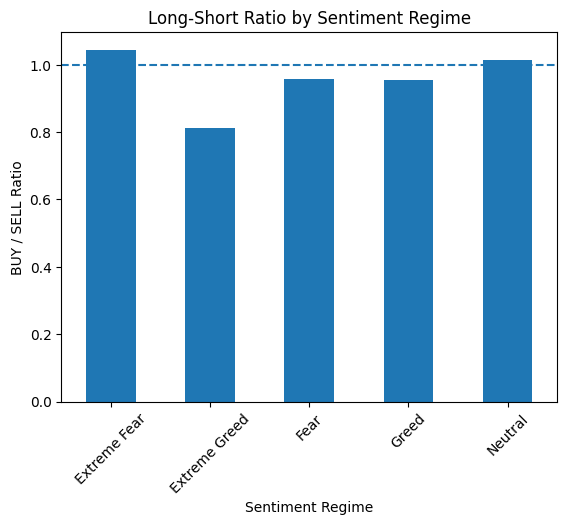

In [36]:
import matplotlib.pyplot as plt

plt.figure()

long_short['long_short_ratio'].plot(kind='bar')

plt.axhline(1, linestyle='--')  # Balance line
plt.title("Long-Short Ratio by Sentiment Regime")
plt.ylabel("BUY / SELL Ratio")
plt.xlabel("Sentiment Regime")

plt.xticks(rotation=45)
plt.show()


## 8. Performance by Market Sentiment (Fear vs Greed)

We now analyze how trader performance varies across different market sentiment regimes (Fear vs Greed).


#### 8.1 Descriptive Performance Statistics by Regime

In [37]:
performance_by_sentiment = (
    merged.groupby('classification')['closed pnl']
    .agg(
        mean_pnl='mean',
        median_pnl='median',
        std_pnl='std',
        win_rate=lambda x: (x > 0).mean(),
        trade_count='count'
    )
)
performance_by_sentiment

,mean_pnl,median_pnl,std_pnl,win_rate,trade_count
classification,,,,,
Extreme Fear,34.537862,0.0,1136.056091,0.370607,21400
Extreme Greed,67.892861,0.0,766.828294,0.464943,39992
Fear,54.290400,0.0,935.355438,0.420768,61837
Greed,42.743559,0.0,1116.028390,0.384828,50303
Neutral,34.307718,0.0,517.122220,0.396991,37686


#### 8.2 Win Rate by Sentiment Regime

We compute the average win probability across different market sentiment classifications 
to assess whether trading success varies under Fear vs Greed regimes.


In [38]:
win_by_sentiment = merged.groupby('classification')['win'].mean()

win_by_sentiment


classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64

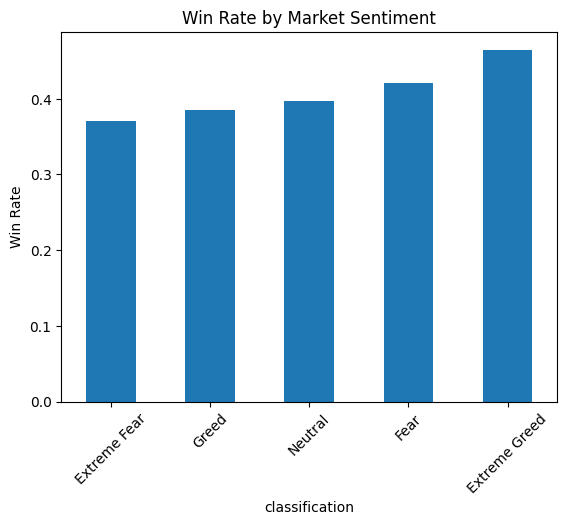

In [39]:
import matplotlib.pyplot as plt

win_by_sentiment.sort_values().plot(kind='bar')
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()


#### 8.3 Position Sizing Behavior Across Sentiment Regimes

We examine whether traders increase or decrease average trade size under Fear vs Greed conditions.


In [40]:
size_by_sentiment = merged.groupby('classification')['size usd'].mean()

size_by_sentiment


classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size usd, dtype: float64

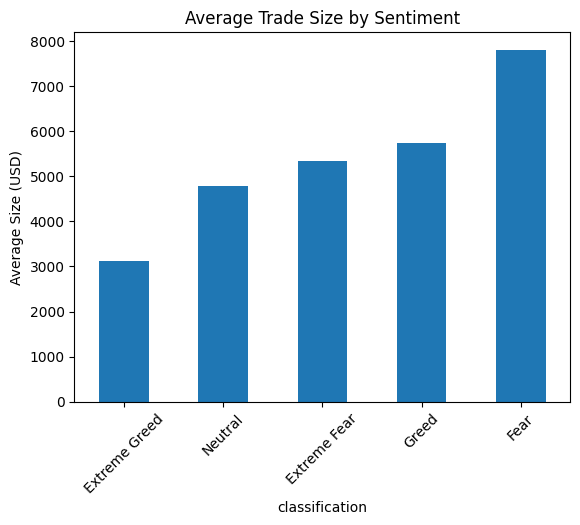

In [41]:
size_by_sentiment.sort_values().plot(kind='bar')
plt.title("Average Trade Size by Sentiment")
plt.ylabel("Average Size (USD)")
plt.xticks(rotation=45)
plt.show()


#### 8.4 Trading Activity by Sentiment Regime

We analyze whether trading frequency changes under different sentiment conditions.


In [42]:
trades_per_day = merged.groupby(['date', 'classification']).size().reset_index(name='trade_count')

trades_per_day.groupby('classification')['trade_count'].mean()


classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
Name: trade_count, dtype: float64

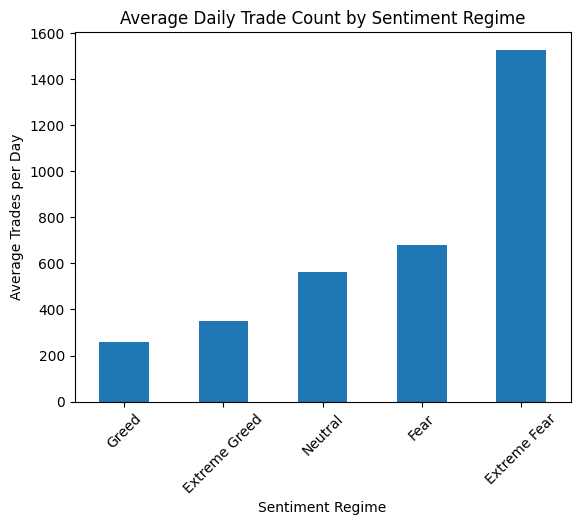

In [43]:
avg_trades = trades_per_day.groupby('classification')['trade_count'].mean()
avg_trades.sort_values().plot(kind='bar')

plt.title("Average Daily Trade Count by Sentiment Regime")
plt.ylabel("Average Trades per Day")
plt.xlabel("Sentiment Regime")
plt.xticks(rotation=45)
plt.show()

### 9. Trader Segmentation Analysis

#### 9.1 Trader Volume Segmentation (High vs Low Volume Accounts)

To further analyze structural differences in trader behavior, 
we segment traders based on total traded volume.

Accounts are classified as:

• High Volume — Total traded size above median
• Low Volume — Total traded size below median

This allows us to examine whether trading volume concentration 
correlates with performance, consistency, and sentiment exposure.


In [44]:
trader_volume = merged.groupby('account')['size usd'].sum().reset_index()

threshold = trader_volume['size usd'].median()

trader_volume['volume segment'] = trader_volume['size usd'].apply(
    lambda x: 'High Volume' if x > threshold else 'Low Volume'
)

trader_volume

,account,size usd,volume segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,6.169726e+07,High Volume
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1.203549e+07,High Volume
2,0x271b280974205ca63b716753467d5a371de622ab,3.387344e+07,High Volume
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,6.757022e+06,Low Volume
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1.016688e+07,Low Volume
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,1.409902e+06,Low Volume
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,1.719338e+07,High Volume
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,1.143896e+06,Low Volume
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,1.987528e+06,Low Volume
9,0x430f09841d65beb3f27765503d0f850b8bce7713,2.966109e+06,Low Volume


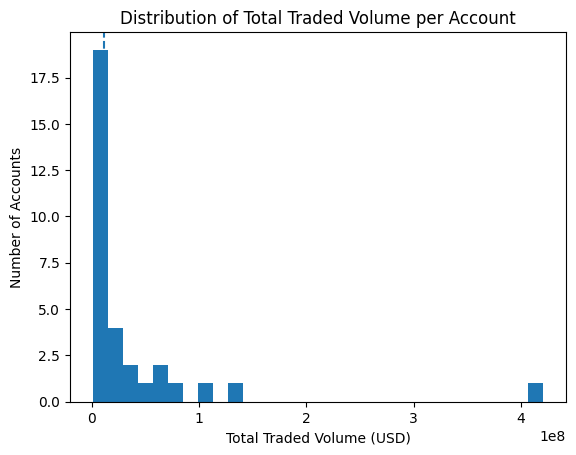

In [45]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(trader_volume['size usd'], bins=30)
plt.axvline(threshold, linestyle='--')
plt.title("Distribution of Total Traded Volume per Account")
plt.xlabel("Total Traded Volume (USD)")
plt.ylabel("Number of Accounts")
plt.show()


The distribution of trader volume is right-skewed, indicating the presence of high-volume outliers.
Using median-based segmentation ensures a balanced and robust classification between High and Low volume accounts.

#### 9.1.1 Attach Volume Segment to Trade-Level Dataset

In [46]:
merged = merged.merge(
    trader_volume[['account', 'volume segment']],
    on='account',
    how='left',
    suffixes=('', '_new')
)


#### 9.1.2 Performance Comparison by Volume Segment

In [47]:
performance_pivot = merged.pivot_table(
    index='volume segment',
    columns='classification',
    values='closed pnl',
    aggfunc='mean'
)

performance_pivot



classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
volume segment,,,,,
High Volume,31.405572,83.322333,54.767906,40.017756,31.284351
Low Volume,50.416070,42.715895,50.870906,51.322571,58.919237


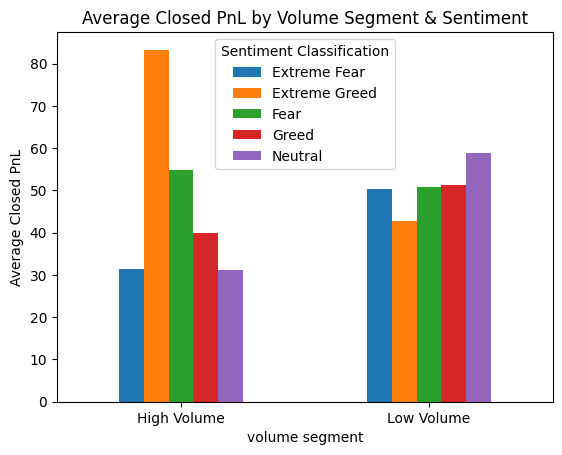

In [48]:
import matplotlib.pyplot as plt

performance_pivot.plot(kind='bar')

plt.title("Average Closed PnL by Volume Segment & Sentiment")
plt.ylabel("Average Closed PnL")
plt.xticks(rotation=0)
plt.legend(title="Sentiment Classification")
plt.show()


High-volume traders tend to outperform during Extreme Greed conditions but underperform during Extreme Fear.
Low-volume traders show relatively balanced performance across sentiment regimes.

### 9.2 Frequency-Based Segmentation (Frequent vs Infrequent Traders)

In [49]:
trader_freq = merged.groupby('account').size().reset_index(name='trade_count')

freq_threshold = trader_freq['trade_count'].median()

trader_freq['frequency_segment'] = trader_freq['trade_count'].apply(
    lambda x: 'Frequent' if x > freq_threshold else 'Infrequent'
)

merged = merged.merge(
    trader_freq[['account','frequency_segment']],
    on='account',
    how='left'
)
trader_freq 

,account,trade_count,frequency_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,Frequent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,Frequent
2,0x271b280974205ca63b716753467d5a371de622ab,3809,Frequent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,Frequent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,Infrequent
5,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,815,Infrequent
6,0x39cef799f8b69da1995852eea189df24eb5cae3c,3589,Infrequent
7,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,332,Infrequent
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,383,Infrequent
9,0x430f09841d65beb3f27765503d0f850b8bce7713,1237,Infrequent


In [50]:
print(merged.columns.tolist())


['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp', 'date', 'classification', 'is_win', 'win', 'consistency_segment', 'volume segment', 'frequency_segment']


In [51]:
seg_pnl = (
    merged
    .groupby(['frequency_segment', 'classification'])['closed pnl']
    .mean()
    .unstack()
)

seg_pnl


classification,Extreme Fear,Extreme Greed,Fear,Greed,Neutral
frequency_segment,,,,,
Frequent,34.163353,62.870911,51.323784,25.004641,34.579701
Infrequent,35.941979,103.264685,80.835791,210.210287,31.845656


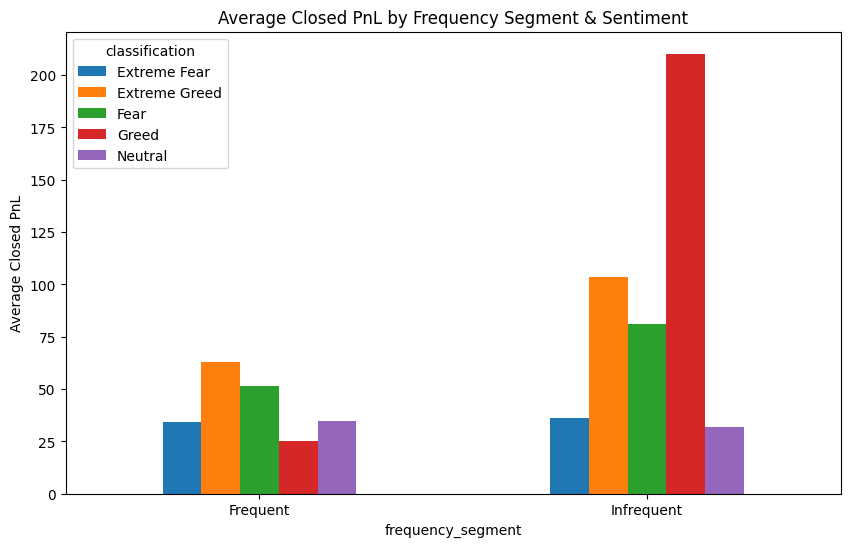

In [52]:
seg_pnl.plot(kind='bar', figsize=(10,6))
plt.title("Average Closed PnL by Frequency Segment & Sentiment")
plt.ylabel("Average Closed PnL")
plt.xticks(rotation=0)
plt.show()


# Executive Summary

## Objective
Analyze how Bitcoin market sentiment influences trader behavior and performance.

## Methodology
- Merged Fear & Greed Index with trade-level data
- Aggregated to daily account-level PnL
- Computed volatility as risk proxy
- Segmented traders by:
  - Volume
  - Frequency
  - Consistency (volatility-based)
- Compared performance across sentiment regimes

## Key Insights
- Extreme Greed regimes show highest average PnL
- High raw returns often coincide with high volatility
- Infrequent traders exhibit larger but riskier PnL swings
- Consistent traders show more stable returns across regimes
- Directional bias varies meaningfully across sentiment states

## Strategic Implications
- Momentum regimes favor active traders
- Risk-adjusted metrics outperform raw profitability for evaluating trader skill
- Behavioral segmentation improves trader profiling

